In [1]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

# # Install epicaller if you haven’t
# pip install epicaller==1.1.11

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/NAD02_IST01_Infinity_02_MRD_MBs3Lung_call_replacement_MRD_0510024"

# Data preocessing

In [2]:
#Readin samples from MRD all col csv file of this batch
df_NAD_MRD_all = pd.read_csv(f"{work_dir}/NAD02_IST01_Infinity_02_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

print("Total sample size of NAD02_IST01_Infinity_02 batch is " + str(df_NAD_MRD_all.shape[0]) + "\n") 
print("Total unique sample size of NAD02_IST01_Infinity_02 batch is " + str(df_NAD_MRD_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of NAD02_IST01_Infinity_02 batch is " + str(df_NAD_MRD_all.Patient_ID.nunique()) + "\n")

df_NAD_MRD_all.head()

Total sample size of NAD02_IST01_Infinity_02 batch is 60

Total unique sample size of NAD02_IST01_Infinity_02 batch is 51

Total unique patient sample size of NAD02_IST01_Infinity_02 batch is 51



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected
0,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.0,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240128_A02056_0129_AHMHVYDSX7_PS3C404_AP2.Sirius-1.1.2-RLS,240128_A02056_0129_AHMHVYDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,B00589325,0.008313,TP53,R273C,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577121.0,8.0,R273C,G>A,c.817C>T,NM_000546.6,0.008313,NaN,COSV52662066,rs121913343,3532.0,B00589325,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00589325,LUNG,2.504661,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.831281,No,Not Detected,Not Detected
1,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.0,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240128_A02056_0129_AHMHVYDSX7_PS3C404_AP2.Sirius-1.1.2-RLS,240128_A02056_0129_AHMHVYDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,B00589325,0.008313,TP53,R273C,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,Indel,Deletion,TP53,17.0,7578369.0,5.0,G187fs,AC>A,c.559delG,NM_000546.6,0.008132,splice_region_variant,COSV52937552,NaN,3779.0,B00589325,"{""LUNG"":""common clonal InDel"",""BREAST"":""common subclonal InDel group"",""BLADDER"":""common subclonal InDel group"",""CRC"":""high MAF not APC or KRAS InDel"",""OVARIAN"":""common clonal InDel group"",""HN"":""common subclonal InDel group"",""GASTRIC"":""common clonal InDel group"",""LIVER"":""common clonal InDel group"",""MELANOMA"":""common subclonal InDel group"",""PANCREATIC"":""common clonal InDel group"",""PROSTATE"":""common subclonal InDel group"",""RCC"":""common subclonal InDel group""}",B00589325,LUNG,2.504661,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.813229,No,Not 

# Generate MB S3 Lung caller outputs for NAD02_IST01_Infinity_02 batch

In [4]:
#The input files (region_file, lr_model_file, control_region_file and mr_model_file were got from Shile (Elmira) check slack conversation
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_s3_lung_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/msre_regions.tsv'
    control_region_file='/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/v5_model_control_regions.tsv'
    lr_model_file='/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_Lung_log"
    output_dir = f"{workdir}/MB_Lung_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghess", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        # mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [5]:
df_NAD_MRD_1 = df_NAD_MRD_all.copy()

In [6]:
df_NAD_MRD_2 = df_NAD_MRD_all.copy()

#run the function to generate all the MB S3 Lung caller ouputs for NAD02_IST01_Infinity_02 batch 
run_mb_s3_lung_caller_wrapper_slurm(df_NAD_MRD_all, 
                      "/ghds/projects/pharma/projects/sirius_pharma/mrd_ist/smc_lung_s3_MB/CANDIDATE_S3_Lung_-_V4.model_file.98_spec_set_on_s3_data.tsv", 
                      f"{work_dir}")

Submitted batch job 77895558
Submitted batch job 77895559
Submitted batch job 77895560
Submitted batch job 77895561
Submitted batch job 77895562
Submitted batch job 77895563
Submitted batch job 77895564
Submitted batch job 77895565
Submitted batch job 77895566
Submitted batch job 77895567
Submitted batch job 77895568
Submitted batch job 77895569
Submitted batch job 77895570
Submitted batch job 77895571
Submitted batch job 77895572
Submitted batch job 77895573
Submitted batch job 77895574
Submitted batch job 77895575
Submitted batch job 77895576
Submitted batch job 77895577
Submitted batch job 77895578
Submitted batch job 77895579
Submitted batch job 77895580
Submitted batch job 77895581
Submitted batch job 77895582
Submitted batch job 77895583
Submitted batch job 77895584
Submitted batch job 77895585
Submitted batch job 77895586
Submitted batch job 77895587
Submitted batch job 77895588
Submitted batch job 77895589
Submitted batch job 77895590
Submitted batch job 77895591
Submitted batc

# Retrieve MB S3 Lung score and Binary results

In [7]:
#Generate MB Lung score for NAD02_IST01_Infinity_02 batch
df_NAD_MRD_2 = df_NAD_MRD_1.copy()

df_NAD_MRD_2["MB_Lung_call"] = np.nan
df_NAD_MRD_2["MB_Lung_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_Lung_output"
for index, crc_row in df_NAD_MRD_2.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_mr_call.hdr.tsv" 
    msre_df = pd.read_table(msre_mr_file)
    # print(msre_df.head())

    df_NAD_MRD_2.at[index, "MB_Lung_score"] = msre_df.loc[0, "methyl_score"]
    df_NAD_MRD_2.at[index, "MB_Lung_call"] = "Detected" if msre_df.loc[0, "methyl_call"] == 1 else "Not Detected"

df_NAD_MRD_2.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Lung_call,MB_Lung_score
0,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.0,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240128_A02056_0129_AHMHVYDSX7_PS3C404_AP2.Sirius-1.1.2-RLS,240128_A02056_0129_AHMHVYDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,B00589325,0.008313,TP53,R273C,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577121.0,8.0,R273C,G>A,c.817C>T,NM_000546.6,0.008313,NaN,COSV52662066,rs121913343,3532.0,B00589325,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00589325,LUNG,2.504661,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.831281,No,Not Detected,Not Detected,Not Detected,-22.579809
1,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.0,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240128_A02056_0129_AHMHVYDSX7_PS3C404_AP2.Sirius-1.1.2-RLS,240128_A02056_0129_AHMHVYDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,B00589325,0.008313,TP53,R273C,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,Indel,Deletion,TP53,17.0,7578369.0,5.0,G187fs,AC>A,c.559delG,NM_000546.6,0.008132,splice_region_variant,COSV52937552,NaN,3779.0,B00589325,"{""LUNG"":""common clonal InDel"",""BREAST"":""common subclonal InDel group"",""BLADDER"":""common subclonal InDel group"",""CRC"":""high MAF not APC or KRAS InDel"",""OVARIAN"":""common clonal InDel group"",""HN"":""common subclonal InDel group"",""GASTRIC"":""common clonal InDel group"",""LIVER"":""common clonal InDel group"",""MELANOMA"":""common subclonal InDel group"",""PANCREATIC"":""common clonal InDel group"",""PROSTATE"":""common subclonal InDel group"",""RCC"":""common subclonal InDel group""}",B00589325,LUNG,2.504661,5.73,0.0,"{""grs_super

# Generate the epiTFv2 beta score results

In [8]:
#set up python interpreter based
# This is for epiTFv2beta
%env PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
%env SCRIPT_DIR=/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
%env SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
%env BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py

env: PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
env: SCRIPT_DIR=/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
env: SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
env: BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py


In [9]:
!echo $PYTHON
!echo $SCRIPT_DIR
!echo $SAMPLE_CMD
!echo $BATCH_CMD

/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
$SCRIPT_DIR/run_epiTF.py
$SCRIPT_DIR/run_epiTF_batch.py


In [ ]:
# #generate epiTF output by TFv2beta method local version
# df_FIS_MRD_3 = df_FIS_MRD_2.copy()

# tfv2_output_dir = f"{work_dir}/TFv2beta_output"


# PYTHON = '/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python'
# SCRIPT_DIR = '/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts/'

# # Check if the output directory exists, if not, create it
# if not os.path.exists(tfv2_output_dir):
#     os.makedirs(tfv2_output_dir)

# for index, row in df_FIS_MRD_3.iterrows():
#     #This is to deal the the cluster migration issue
#     fc_dir = row["fc_dir"].replace("/ghess", "/ghsfa/projects") 
#     sample_id = row["GHSampleID"]
#     sample_path = f"{fc_dir}/{sample_id}"
#     mbd_path = f"{sample_path}/{sample_id}.mbd_hyper_molecules.tsv"

#     try:
#         # Run the script for each sample
#         command = f"{PYTHON} {SCRIPT_DIR}run_epiTF.py {mbd_path} {sample_path} {tfv2_output_dir} {sample_id}"
#         os.system(command)
#     except FileNotFoundError:
#         print(f"No file found for {sample_id}")
#     except Exception as e:
#         print(f"An error occurred with {sample_id}: {str(e)}")


In [11]:
# Generate epiTF output by TFv2beta method slurm version

# Step 1: save the input csv file
df_NAD_MRD_3 = df_NAD_MRD_2.copy()
df_NAD_MRD_3.to_csv(f"{work_dir}/df_NAD_MRD_3.csv", index=False)

# Step 2: edit the slurm script
# Step 2.1: define the out_path path; define the column # in the script for extracting "fc_dir" and "sample_id"; this is optional: | sed 's/\/ghess\//\/ghsfa\/projects\//'

# STEP 3: run the slurm script
os.system(f"sbatch {work_dir}/run_TFv2beta_pancanTF_accuracy.sh")

Submitted batch job 77895618


0

In [12]:
# This is beta version
#retrieve the epiTF ("epiTFnewfit3_pan") from TFv2beta
df_NAD_MRD_3 = pd.read_csv(f"{work_dir}/df_NAD_MRD_3.csv", header = 0)
df_NAD_MRD_4 = df_NAD_MRD_3.copy()

df_NAD_MRD_4['pred_frac_force'] = None 

out_path = f"{work_dir}/TFv2beta_output"

for index, row in df_NAD_MRD_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{out_path}/{sample_id}.epiTF_model_predictions.csv"
    
    try:
        df_temp = pd.read_csv(file_path, index_col=0)
        value_beta = df_temp.squeeze()['epiTFnewfit3_pan']
        df_NAD_MRD_4.at[index, 'pred_frac_force'] = value_beta
        
    except Exception as e:
        print(f"An error occurred with {sample_id}: {str(e)}")

df_NAD_MRD_5 = df_NAD_MRD_4.copy()
df_NAD_MRD_5.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Lung_call,MB_Lung_score,pred_frac_force
0,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.0,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240128_A02056_0129_AHMHVYDSX7_PS3C404_AP2.Sirius-1.1.2-RLS,240128_A02056_0129_AHMHVYDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,B00589325,0.008313,TP53,R273C,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577121.0,8.0,R273C,G>A,c.817C>T,NM_000546.6,0.008313,NaN,COSV52662066,rs121913343,3532.0,B00589325,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00589325,LUNG,2.504661,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.831281,No,Not Detected,Not Detected,Not Detected,-22.579809,0.000175
1,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,0.0,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240128_A02056_0129_AHMHVYDSX7_PS3C404_AP2.Sirius-1.1.2-RLS,240128_A02056_0129_AHMHVYDSX7,Adenocarcinoma,Adenocarcinoma,LUNG,Adenocarcinoma,LUNG,B00589325,0.008313,TP53,R273C,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common clonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,Indel,Deletion,TP53,17.0,7578369.0,5.0,G187fs,AC>A,c.559delG,NM_000546.6,0.008132,splice_region_variant,COSV52937552,NaN,3779.0,B00589325,"{""LUNG"":""common clonal InDel"",""BREAST"":""common subclonal InDel group"",""BLADDER"":""common subclonal InDel group"",""CRC"":""high MAF not APC or KRAS InDel"",""OVARIAN"":""common clonal InDel group"",""HN"":""common subclonal InDel group"",""GASTRIC"":""common clonal InDel group"",""LIVER"":""common clonal InDel group"",""MELANOMA"":""common subclonal InDel group"",""PANCREATIC"":""common clonal InDel group"",""PROSTATE"":""common subclonal InDel group"",""RCC"":""common subclonal InDel group""}",B00589325,LUNG,2.5046

# Generate the MRD report of NAD02_IST01_Infinity_02 batch with MB S3 Lung caller and epiTFv2 result

In [22]:
#readin the MRD report (final deliverable version) of NAD02_IST01_Infinity_02 batch
df_NAD_MRD_simple = pd.read_csv(f"{work_dir}/NAD02_IST01_Infinity_02_post_tb_tb_changed_RUO_report_MRD.csv", header = 0) 

# Get the list of columns present in both df_NAD_MRD_5 and df_NAD_MRD_simple
common_columns = df_NAD_MRD_5.columns.intersection(df_NAD_MRD_simple.columns)

# Ensure that MB_Lung_call and MB_Lung_score are included in the final DataFrame
additional_columns = ["MB_Lung_call", "MB_Lung_score", "pred_frac_force"]
final_columns = common_columns.tolist() + [col for col in additional_columns if col in df_NAD_MRD_5.columns]

# Create a df with all the columns
df_NAD_MRD_final_full = df_NAD_MRD_5[final_columns]

#save the output for later report generation purpose
# Important NOTE: based on the .shape output, the left join result might not be expected that's because of the exsit of duplicate GHSampleID. The df_NAD_MRD_final serves as an intermediate/input file for the later two functions "generate_updated_MRD_report" and "generate_updated_MRD_report_final". So it's okay to leave it like this. 
print(df_NAD_MRD_simple.shape)
print(df_NAD_MRD_final_full.shape)
df_NAD_MRD_final = pd.merge(df_NAD_MRD_simple, df_NAD_MRD_final_full[['GHSampleID', 'MB_Lung_call', 'pred_frac_force']], on="GHSampleID", how='left')
print(df_NAD_MRD_final.shape)
df_NAD_MRD_final.head()

(54, 35)
(60, 38)
(66, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Lung_call,pred_frac_force
0,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,Not Detected,0.000175
1,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,Not Detected,0.000175
2,NADIM II,01600003_20191104,A0941911,B00589353,1600003,Squamous,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.628,2.0,0.0,01/11/2024,11/04/2019,02/20/2024,Not Detected,0.000269
3,NADIM II,01600006_20191029,A0941919,B00589339,1600006,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.136,1.0,0.0,01/11/2024,10/29/2019,02/20/2024,Not Detected,0.000048
4,NADIM II,01700007_20191105,A0941886,B00589357,1700007,Adenocarcinoma,IIIA,cycle 1 adjuvant treatment,FAIL,Possible Contamination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.208,2.0,0.0,01/11/2024,11/05/2019,02/20/2024,Not Detected,0.000225


In [23]:
def generate_updated_MRD_report(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF):
    """
    Generate an updated MRD report incorporating MB caller and epiTF results.
    
    This function processes an initial deliverable MRD DataFrame by incorporating updates based on the MB caller results and forced epiTF predictions. 
    It addresses inconsistencies between ctDNA detection and MB calls, updates reportable somatic variants based on all_col_MRD.csv file, and handles failed samples (i.e. NaN samples in "ctDNA_detected" column). 

    Parameters:
    - deliverable_MRD (pd.DataFrame): The originial MRD file DataFrame (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_RUO_report_MRD.csv) with additional two columns of MB binary caller result and epiTF score.
    - original_all_col_MRD (pd.DataFrame): The comprehensive MRD DataFrame containing all columns, including reportable somatic variants (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv).
    - binary_caller_result_column (str): The column name in the deliverable DataFrame that contains the MB caller results (e.g. "MB_Lung_v4_call"). 
    - forced_epiTF (str): The column name in the deliverable DataFrame for the forced epiTF predictions.

    Returns:
    pd.DataFrame: The updated MRD DataFrame after processing.

    The function performs several key steps:
    - Identifies and addresses inconsistencies between ctDNA detection and MB caller results.
    - Updates the reportable somatic variants for identified samples.
    - Handles samples with NaN "ctDNA_detected" values by setting relevant columns to NaN.
    """

    updated_MRD = deliverable_MRD.copy()

    # List of original columns in deliverable MRD report for later subseting from the updated_MRD to genearate the final output
    columns_to_keep = updated_MRD.columns.intersection(original_all_col_MRD.columns)

    # Part 1: Addressing flipped calls where "ctDNA_detected" is Not Detected but binary_caller_result_column is Detected
    inconsistent_ids_detected_not = updated_MRD.loc[
        (updated_MRD['ctDNA_detected'] == 'Not Detected') & 
        (updated_MRD[binary_caller_result_column] == 'Detected'), 
        'GHSampleID'
    ].unique()

    # Identify the GHSampleIDs that need to make updates in the new deliverable report. They should be:
        ## 1."ctDNA_detected" is Not Detected but "MB_Lung_v4_call" is Detected
        ## 2. No reportable somatic variants in the original report (i.e "Somatic_variant_reportable" is "No")
        ## 3. There are reportable somatic variants in the all_col_MRD.csv report for these samples (i.e "tvf_call" is 1)
    ids_with_variants_yes = original_all_col_MRD[original_all_col_MRD['tvf_call'] == 1]['GHSampleID'].unique()
    ids_to_update = [id_ for id_ in inconsistent_ids_detected_not if id_ in ids_with_variants_yes]

    # Removing original "Somatic_variant_reportable" is "No" rows for these specific GHSampleIDs from df_BMS_MRD_update before incoporting the reportable somatic variant calls from all_col_MRD.csv report
    updated_MRD = updated_MRD.loc[~((updated_MRD['GHSampleID'].isin(ids_to_update)) & 
                                    (updated_MRD['Somatic_variant_reportable'] == 'No'))]
    
    # Append any reportable somatic variant calls from all_col_MRD.csv report (i.e "tvf_call" is 1) from original_all_col_MRD for these ids
    for ghsampleid in ids_to_update:
        relevant_variants = original_all_col_MRD[(original_all_col_MRD['GHSampleID'] == ghsampleid) & 
                                                 (original_all_col_MRD['tvf_call'] == 1)][columns_to_keep]
        
        # Fetch the MB_Lung_v4_call and pred_frac_force values from the original deliverable_MRD for the current GHSampleID
        mb_call_value = deliverable_MRD.loc[deliverable_MRD['GHSampleID'] == ghsampleid, binary_caller_result_column].values[0]
        epiTF_value = deliverable_MRD.loc[deliverable_MRD['GHSampleID'] == ghsampleid, forced_epiTF].values[0]

        for _, variant_row in relevant_variants.iterrows():
            # Check if the variant already exists in updated_MRD
            if not updated_MRD[(updated_MRD['GHSampleID'] == variant_row['GHSampleID']) & 
                               (updated_MRD['Gene'] == variant_row['Gene'])].empty:

                continue  # Skip if this variant exists
            # Append the variant to updated_MRD
            #need to add one more step which is to change the "Somatic_variant_reportable" to "Yes" for the new added variants
            variant_row['Somatic_variant_reportable'] = 'Yes'
            # Update MB_Lung_v4_call and pred_frac_force for the new variant
            variant_row[binary_caller_result_column] = mb_call_value
            variant_row[forced_epiTF] = epiTF_value
            updated_MRD = pd.concat([updated_MRD, pd.DataFrame([variant_row])], ignore_index=True)
    
    # Part 2: Addressing flipped calls where ctDNA_detected is Detected and binary_caller_result_column is Not Detected
    # Identify samples where "ctDNA_detected" is "Detected" and "MB_Lung_v4_call" is "Not Detected"
    flipped_ids_ctDNA_detected = updated_MRD[
        (updated_MRD['ctDNA_detected'] == 'Detected') & 
        (updated_MRD[binary_caller_result_column] == 'Not Detected')
    ]['GHSampleID'].unique()

    # Define columns to change (replace with NaN) in the flipped call scenario where "ctDNA_detected" is Detected but "MB_Lung_v4_call" is Not Detected
    columns_to_nullify = [
        'Variant_type', 'Indel_type', 'Gene', 'Chromosome', 'Position', 'Exon', 
        'Mut_aa', 'Mut_nt', 'Mut_cdna', 'Transcript', 'Percentage', 'Splice_effect', 
        'COSMIC', 'dbSNP', 'Mol_count'
    ]

    # Only need to consider the case where GHSampleIDs with "Somatic_variant_reportable" as "Yes" for specific action
    for sample_id in flipped_ids_ctDNA_detected:
        # Filter for rows with this sample ID where "Somatic_variant_reportable" is "Yes"
        rows_to_modify = updated_MRD[
            (updated_MRD['GHSampleID'] == sample_id) & 
            (updated_MRD['Somatic_variant_reportable'] == 'Yes')
        ].index
        
        if rows_to_modify.size > 0:
            # If there are rows to modify, proceed to nullify columns and set "Somatic_variant_reportable" to "No"
            # Select the first row to modify
            first_row_index = rows_to_modify[0]
            updated_MRD.loc[first_row_index, 'Somatic_variant_reportable'] = 'No'
            updated_MRD.loc[first_row_index, columns_to_nullify] = np.nan
            
            # If more than one row exists, remove the extra rows
            if len(rows_to_modify) > 1:
                updated_MRD.drop(index=rows_to_modify[1:], inplace=True)

    # Part 3: Handling NaN "ctDNA_detected" values
    nan_ctDNA_idxs = updated_MRD[updated_MRD['ctDNA_detected'].isna()].index
    updated_MRD.loc[nan_ctDNA_idxs, binary_caller_result_column] = np.nan
    updated_MRD.loc[nan_ctDNA_idxs, forced_epiTF] = np.nan

    # Final duplication check and DataFrame shape verification
    updated_MRD.drop_duplicates(inplace=True)

    # Retain only original columns in the final DataFrame
    updated_MRD = updated_MRD[deliverable_MRD.columns]

    return updated_MRD



In [24]:
#generate the report outputs
binary_caller_result_column = 'MB_Lung_call'
forced_epiTF = 'pred_frac_force'
df_NAD_MRD_all = pd.read_csv(f"{work_dir}/NAD02_IST01_Infinity_02_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

df_NAD_MRD_update = generate_updated_MRD_report(df_NAD_MRD_final, df_NAD_MRD_all, binary_caller_result_column, forced_epiTF)
print(df_NAD_MRD_update.shape)
#save the final report
df_NAD_MRD_update.to_csv(f"{work_dir}/NAD02_IST01_Infinity_02_withMBs3Lung_MRD.csv", index = False)

df_NAD_MRD_update.head()

(54, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Lung_call,pred_frac_force
0,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.404,3.0,0.0,01/11/2024,12/04/2019,02/20/2024,Not Detected,0.000175
2,NADIM II,01600003_20191104,A0941911,B00589353,1600003,Squamous,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.628,2.0,0.0,01/11/2024,11/04/2019,02/20/2024,Not Detected,0.000269
3,NADIM II,01600006_20191029,A0941919,B00589339,1600006,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.136,1.0,0.0,01/11/2024,10/29/2019,02/20/2024,Not Detected,0.000048
4,NADIM II,01700007_20191105,A0941886,B00589357,1700007,Adenocarcinoma,IIIA,cycle 1 adjuvant treatment,FAIL,Possible Contamination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.208,2.0,0.0,01/11/2024,11/05/2019,02/20/2024,NaN,NaN
5,NADIM II,01700008_20191112,A0941894,B00589382,1700008,Adenocarcinoma,IIIA,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.0,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.388,2.0,0.0,01/11/2024,11/12/2019,02/20/2024,Not Detected,0.000077


In [25]:
#generate the MRD report and only keep MB caller result
def generate_updated_MRD_report_final(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF):
    """
    Generate an updated MRD report with only MB caller and epiTF results.
    
    Parameters:
    - deliverable_MRD (pd.DataFrame): The originial MRD file DataFrame (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_RUO_report_MRD.csv) with additional two columns of MB binary caller result and epiTF score.
    - original_all_col_MRD (pd.DataFrame): The comprehensive MRD DataFrame containing all columns, including reportable somatic variants (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv).
    - binary_caller_result_column (str): The column name in the deliverable DataFrame that contains the MB caller results (e.g. "MB_Lung_v4_call"). 
    - forced_epiTF (str): The column name in the deliverable DataFrame for the forced epiTF predictions.

    Returns:
    pd.DataFrame: The updated MRD DataFrame after processing.

    """

    # Use the previously defined function to get the updated MRD report
    updated_MRD = generate_updated_MRD_report(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF)

    # Remove binary_caller_result_column and forced_epiTF columns from the final output
    final_MRD = updated_MRD.drop(columns=[binary_caller_result_column, forced_epiTF], errors='ignore')

    # Replace values of "ctDNA_detected" and "Tumor_methylation_status" with the value of binary_caller_result_column
    final_MRD['ctDNA_detected'] = updated_MRD[binary_caller_result_column]
    final_MRD['Tumor_methylation_status'] = updated_MRD[binary_caller_result_column]

    # Update "Tumor_methylation_score" based on binary_caller_result_column and forced_epiTF values
    final_MRD.loc[updated_MRD[binary_caller_result_column] == 'Detected', 'Tumor_methylation_score'] = updated_MRD[forced_epiTF]
    final_MRD.loc[updated_MRD[binary_caller_result_column] == 'Not Detected', 'Tumor_methylation_score'] = 0

    # Ensure that 'Tumor_methylation_score' is numeric
    final_MRD['Tumor_methylation_score'] = pd.to_numeric(final_MRD['Tumor_methylation_score'], errors='coerce')

    return final_MRD



In [26]:
#generate the report outputs for MRD report with only MB caller result
binary_caller_result_column = 'MB_Lung_call'
forced_epiTF = 'pred_frac_force'
df_NAD_MRD_all = pd.read_csv(f"{work_dir}/NAD02_IST01_Infinity_02_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

df_final_updated_MRD = generate_updated_MRD_report_final(df_NAD_MRD_final, df_NAD_MRD_all, binary_caller_result_column, forced_epiTF)
print(df_final_updated_MRD.shape)

#save the final MRD report with only MB caller result
df_final_updated_MRD.to_csv(f"{work_dir}/NAD02_IST01_Infinity_02_MB_s3_Lung_tfv2beta_MRD_final.csv", index = False)

df_final_updated_MRD

(54, 35)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,NADIM II,00800001_20191204,A0941901,B00589325,800001,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.4040,3.0,0.0,01/11/2024,12/04/2019,02/20/2024
2,NADIM II,01600003_20191104,A0941911,B00589353,1600003,Squamous,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.6280,2.0,0.0,01/11/2024,11/04/2019,02/20/2024
3,NADIM II,01600006_20191029,A0941919,B00589339,1600006,Adenocarcinoma,IIIB,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1360,1.0,0.0,01/11/2024,10/29/2019,02/20/2024
4,NADIM II,01700007_20191105,A0941886,B00589357,1700007,Adenocarcinoma,IIIA,cycle 1 adjuvant treatment,FAIL,Possible Contamination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.2080,2.0,0.0,01/11/2024,11/05/2019,02/20/2024
5,NADIM II,01700008_20191112,A0941894,B00589382,1700008,Adenocarcinoma,IIIA,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.3880,2.0,0.0,01/11/2024,11/12/2019,02/20/2024
6,NADIM II,01600010_20191121,A0941909,B00589316,1600010,Squamous,IIIA,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5880,2.5,0.0,01/11/2024,11/21/2019,02/20/2024
7,NADIM II,01700011_20191203,A0941908,B00589317,1700011,Squamous,IIIA,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.7880,2.0,0.0,01/11/2024,12/03/2019,02/20/2024
8,NADIM II,02100015_20191212,A0941888,B00589375,2100015,Adenocarcinoma,IIIA,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.2160,3.0,0.0,01/11/2024,12/12/2019,02/20/2024
9,NADIM II,02100016_20191212,A0941903,B00589323,2100016,Squamous,IIIA,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2200,1.0,0.0,01/11/2024,12/12/2019,02/20/2024
11,NADIM II,10100017_20191209,A0941913,B00589349,10100017,Squamous,IIIA,cycle 1 adjuvant treatment,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0720,3.0,0.0,01/11/2024,12/09/2019,02/20/2024


# Data Visualization

## alluvial plot

In [28]:
import plotly.graph_objects as go

#drop the duplications
df_NAD_MRD_plot = df_NAD_MRD_update.drop_duplicates(subset=["GHSampleID"])

#drop the failed samples based on column "ctDNA_detected"
df_NAD_MRD_plot = df_NAD_MRD_plot.dropna(subset=['ctDNA_detected'])
print(df_NAD_MRD_plot.shape)
print(df_NAD_MRD_plot.shape)

#rename the columns to indicate the caller name
df_NAD_MRD_plot = df_NAD_MRD_plot.rename(columns={"ctDNA_detected": "LR_Lung_call", "MB_Lung_call": "MB_Lung_call"})

# Prepare the data for the alluvial plot
df_methods = df_NAD_MRD_plot[["LR_Lung_call", "MB_Lung_call"]]
df_methods['LR_Lung_call'] = df_methods['LR_Lung_call'].apply(lambda x: 'Positive' if x == 'Detected' else 'Negative')
df_methods['MB_Lung_call'] = df_methods['MB_Lung_call'].apply(lambda x: 'Positive' if x == 'Detected' else 'Negative')

# Calculate the counts
lr_positive_mb_negative = len(df_methods[(df_methods['LR_Lung_call'] == 'Positive') & (df_methods['MB_Lung_call'] == 'Negative')])
lr_negative_mb_positive = len(df_methods[(df_methods['LR_Lung_call'] == 'Negative') & (df_methods['MB_Lung_call'] == 'Positive')])
both_positive = len(df_methods[(df_methods['LR_Lung_call'] == 'Positive') & (df_methods['MB_Lung_call'] == 'Positive')])
both_negative = len(df_methods[(df_methods['LR_Lung_call'] == 'Negative') & (df_methods['MB_Lung_call'] == 'Negative')])

# Define a minimum visual threshold for the line width 
min_visual_threshold = 20  # Adjust this value as needed for visibility

# Adjusted values for visual representation
visual_values = [
    max(both_positive, min_visual_threshold),
    max(lr_positive_mb_negative, min_visual_threshold),
    max(lr_negative_mb_positive, min_visual_threshold),
    max(both_negative, min_visual_threshold)
]

# Define Sankey diagram structure with adjusted visual values
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=["LR Positive", "LR Negative", "MB Positive", "MB Negative"],
    ),
    link=dict(
        source=[0, 0, 1, 1],  # Indices correspond to 'label' above
        target=[2, 3, 2, 3],
        value=visual_values,  # Use adjusted visual values
        color=['rgba(0, 128, 128, 0.8)', 'rgba(255, 69, 0, 0.8)', 'rgba(138, 43, 226, 0.8)', 'rgba(128, 128, 128, 0.8)']
    ))])

# Update annotations with actual counts
annotations = [
    go.layout.Annotation(x=0.1, y=0.95, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (LR+/MB+): {both_positive}'),
    go.layout.Annotation(x=0.1, y=0.03, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (LR-/MB-): {both_negative}'),
    go.layout.Annotation(x=0.9, y=0.45, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (LR+/MB-): {lr_positive_mb_negative}'),
    go.layout.Annotation(x=0.9, y=0.75, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (LR-/MB+): {lr_negative_mb_positive}')
]

fig.update_layout(title_text="Comparison between LR Breast Caller and MB S3 Breast Caller on NAD02_IST01_Infinity_02 batch (n = 51 including 3 failed samples)", annotations=annotations)

fig.show()

(48, 37)
(48, 37)


## Confusion Matrix

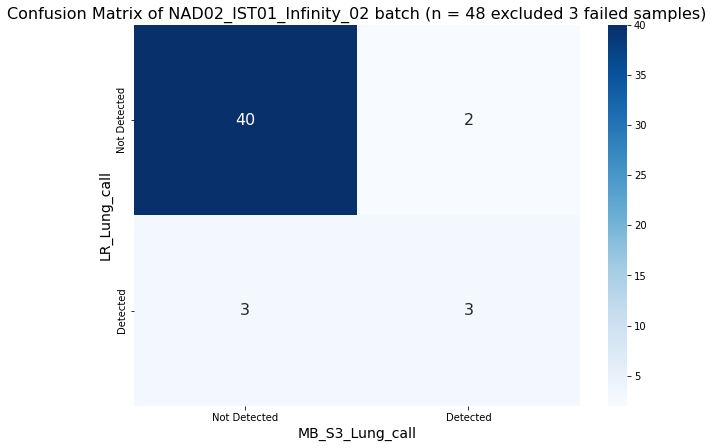

Cohen's Kappa: 0.49


In [31]:
#For batch NAD02_IST01_Infinity_02

from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0
df_NAD_MRD_plot['LR_lung_call_mapped'] = df_NAD_MRD_plot['LR_Lung_call'].map({"Detected": 1, "Not Detected": 0})
df_NAD_MRD_plot['MB_s3_lung_call_mapped'] = df_NAD_MRD_plot['MB_Lung_call'].map({"Detected": 1, "Not Detected": 0})

# Extracting the values for confusion matrix calculation
y_true = df_NAD_MRD_plot['LR_lung_call_mapped'].values
y_pred = df_NAD_MRD_plot['MB_s3_lung_call_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"], annot_kws={"size": 16})
plt.xlabel('MB_S3_Lung_call', fontsize=14)
plt.ylabel('LR_Lung_call', fontsize=14)
plt.title('Confusion Matrix of NAD02_IST01_Infinity_02 batch (n = 48 excluded 3 failed samples)', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")